1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-
y分量形状 (404, 388)
u分量形状 (202, 194)
v分量形状 (202, 194)


C:\Users\85742\AppData\Local\Temp\ipykernel_5460\1600852731.py:50: RuntimeWarning: overflow encountered in ushort_scalars
  ypre = y[j + i * w] - img_re[j + i * w - 1]


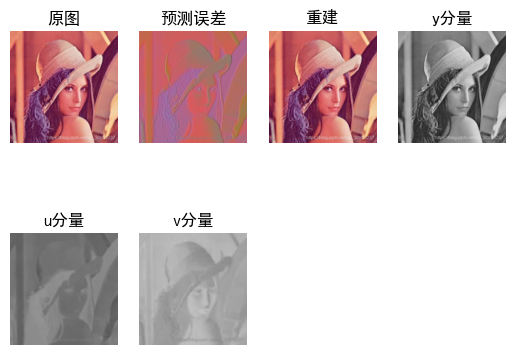

In [10]:
import cv2
import numpy as np

img = cv2.imread('lena.png')
[h, w] = img.shape[:2] 

yvu = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, v, u = cv2.split(yvu)

#下采样
u = cv2.resize(u, (u.shape[1] // 2, u.shape[0] // 2))  
v = cv2.resize(v, (v.shape[1] // 2, v.shape[0] // 2))
print('1-'*50)
print('y分量形状',y.shape)
print('u分量形状',u.shape)
print('v分量形状',v.shape)

import io
f = io.BytesIO()
f.write(y.tobytes())
f.write(u.tobytes())
f.write(v.tobytes())
f.seek(0)

img_np = np.frombuffer(f.read(), np.uint8)  # 原图的yuv420,一定要420,要不然要修改数组截取大小

img_yuv_len = img_np.size
img_y_len = h * w

y = img_np[:img_y_len]
u = img_np[img_y_len:(img_yuv_len - img_y_len) // 2 + img_y_len]  # 要注意 w或h 为单数的情况
v = img_np[(img_yuv_len - img_y_len) // 2 + img_y_len:]

# DPCM
img_re = np.zeros(img_y_len, np.uint16)  
yprebuff = np.zeros(img_y_len, np.uint16)  

radio=512/(1<<8)  
for i in range(h):
    for j in range(w):
        if j == 0:
            ypre = y[j + i * w]-128 
            yprebuff[j + i * w] = (ypre+255)/radio 
            img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+128 
            if img_re[j + i * w]>255:
                img_re[j + i * w] = 255
            yprebuff[j + i * w] = yprebuff[j + i * w]*radio/2

        else:
            ypre = y[j + i * w] - img_re[j + i * w - 1]  
            yprebuff[j + i * w] = (ypre+255) /radio  
            img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+img_re[j + i * w - 1]  # 反量化
            yprebuff[j + i * w] = yprebuff[j + i * w] * radio / 2  # 预测器
            if img_re[j + i * w]>255:
                img_re[j + i * w] = 255
img_re = img_re.astype(np.uint8)
yprebuff = yprebuff.astype(np.uint8) 

# 重建图片
y = y.reshape((h,w)) 

yprebuff = yprebuff.reshape((h,w)) 

img_re = img_re.reshape((h,w))

u = u.reshape((h//2,w//2))
v = v.reshape((h//2,w//2))
ru = cv2.resize(u,(w,h))  
rv = cv2.resize(v,(w,h))

yvu = cv2.merge((y, rv, ru))
bgr = cv2.cvtColor(yvu, cv2.COLOR_YCrCb2BGR)  

yvu_pre = cv2.merge((yprebuff, rv, ru))
bgr_pre = cv2.cvtColor(yvu_pre, cv2.COLOR_YCrCb2BGR) 

yvu_re = cv2.merge((img_re, rv, ru))
bgr_re = cv2.cvtColor(yvu_re, cv2.COLOR_YCrCb2BGR) 

# 显示结果
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.subplot(241), plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)),
plt.title('原图'), plt.axis('off')
plt.subplot(242), plt.imshow(cv2.cvtColor(bgr_pre, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('预测误差'), plt.axis('off')
plt.subplot(243), plt.imshow(cv2.cvtColor(bgr_re, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('重建'), plt.axis('off')

plt.subplot(244), plt.imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB)),
plt.title('y分量'), plt.axis('off')
plt.subplot(245), plt.imshow(cv2.cvtColor(ru, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('u分量'), plt.axis('off')
plt.subplot(246), plt.imshow(cv2.cvtColor(rv, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('v分量'), plt.axis('off')
plt.show()